In [1]:
# Packages
import sympy as sp

# Latex printing
sp.init_printing(use_latex=True)

# Hedgehog ansatz definitions

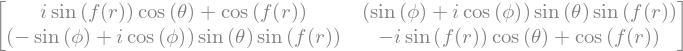

In [2]:
# Spherical coordinates
r = sp.Symbol('r', positive = True)
theta = sp.Symbol(r'\theta')
phi = sp.Symbol(r'\phi')

X = [r, theta, phi]

# Profile function of the Hedgehog ansatz
f = sp.Function('f')(r)

# Adimensional sextic term coupling constant
c6 = sp.Symbol('c_6')
c0 = sp.Symbol('c_0')

# Pauli matrices
tau1 = sp.Matrix(((0,1),(1,0)))
tau2 = sp.Matrix(((0,-sp.I),(sp.I,0)))
tau3 = sp.Matrix(((1,0),(0,-1)))
tau = [tau1, tau2, tau3]

# pi_a * tau_a. n = (sin(theta)*cos(phi), sin(theta)*sin(phi), cos(theta))
Aux = sp.sin(theta)*sp.cos(phi)*tau1 + sp.sin(theta)*sp.sin(phi)*tau2 + sp.cos(theta)*tau3

# Skyrme field hedgehog ansatz
U = sp.simplify(sp.cos(f)*sp.eye(2) + sp.I*Aux*sp.sin(f))
Udagger = sp.simplify(sp.cos(f)*sp.eye(2) - sp.I*Aux*sp.sin(f))

U

In [3]:
# Function to obtain the metric and its inverse
class MT(object):
    def __init__(self, m):
        self.gdd = m
        self.guu = m.inv()

    def __str__(self):
        return "g_dd =\n" + str(self.gdd)

    def dd(self, i, j):
        return self.gdd[i, j]

    def uu(self, i, j):
        return self.guu[i, j]

# Define the metric, g_{ab} and the inverse metric, g^{ab}.

# Metric in spherical coordinates
gdd = sp.Matrix((
    (-1, 0, 0),
    (0, -r**2, 0),
    (0, 0, -r**2*sp.sin(theta)**2)
))

# The inverse is simple in this (diagonal) case
guu = sp.Matrix((
    (-1, 0, 0),
    (0, -1/r**2, 0),
    (0, 0, -1/(r**2*sp.sin(theta)**2))
))

g = MT(gdd)

# Determinant of the metric
gdet = sp.det(gdd)
gdet_sqrt = r**2*sp.sin(theta)

gdet_sqrt

# Skyrme model lagrangian

## $L_{\mu} = U^{\dagger}\partial_{\mu}U$

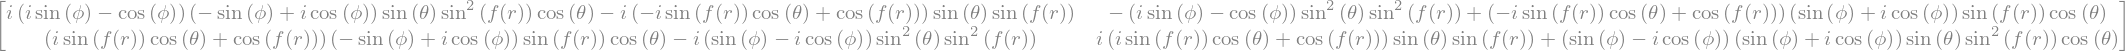

In [4]:
# Left invariant Maurer-Cartan form. It has 4 components, each component is a 2x2 matrix.
Lmu = []

for i in range(3):
    Lmu.append(Udagger*U.diff(X[i]))

Lmu[1]

## $\mathcal{L}_2 = -\frac{1}{2}g^{\mu\nu} Tr \{ L_{\mu}L_{\nu} \}$

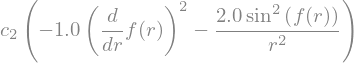

In [5]:
# Quadratic term. It takes less computation time to use the fields U instead of Lmu
c2 = sp.Symbol('c_2')
L2 = 0
for i in range(3):
    for j in range(3):
        L2 -= 0.5*sp.Trace(guu[i,j]*Lmu[i]*Lmu[j]).doit()

L2 = c2*sp.simplify(L2)
L2

## $\mathcal{L}_4 = \frac{1}{4} g^{\mu\nu}g^{\rho\sigma}Tr \{ [L_{\mu}, L_{\nu}][L_{\rho}, L_{\sigma}] \}$

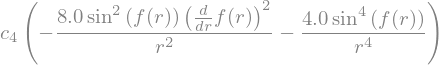

In [6]:
# Quartic term
c4 = sp.Symbol('c_4')
L4 = 0
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                L4 += 0.25*sp.Trace(guu[i,k]*guu[j,l]*(Lmu[i]*Lmu[j] - Lmu[j]*Lmu[i])*(Lmu[k]*Lmu[l] - Lmu[l]*Lmu[k]))
                
L4 = c4*sp.simplify(L4)
L4

## $B^0 = \frac{1}{24\pi^2}\epsilon^{ijk}Tr\{L_{i}L_{j}L_{k}\}$

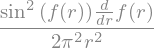

In [7]:
# Topological charge density
B0 = 0
for i in range(3):
    for j in range(3):
        for k in range(3):
            B0 += sp.simplify(sp.LeviCivita(i,j,k)*sp.Trace(Lmu[i]*Lmu[j]*Lmu[k]).doit())

B0 *= sp.simplify(1/(24*sp.pi**2*gdet_sqrt))

B0

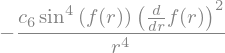

In [8]:
# Sextic term
L6 = sp.simplify(-4*sp.pi**4*c6*B0*B0)

L6

In [9]:
# Pion mass potential term
L0 = sp.simplify(-c0/2*sp.Trace(sp.eye(2) - U).doit())

L0

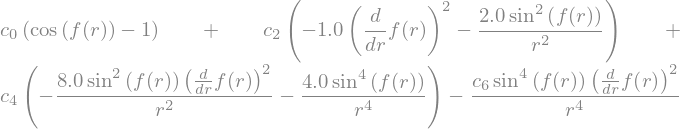

In [10]:
# Lagrangian
Lag = L2 + L4 + L6 + L0

Lag

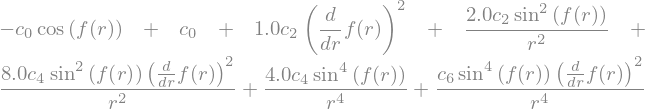

In [11]:
ED = sp.expand(-Lag)
ED

# Equation of motion

## $\frac{1}{\sqrt(-g)}\partial_{\mu}\left( \sqrt{-g}\frac{\partial \mathcal{L}}{\partial (\partial_{\mu}\phi)} \right) - \frac{\partial\mathcal{L}}{\partial \phi} = 0$

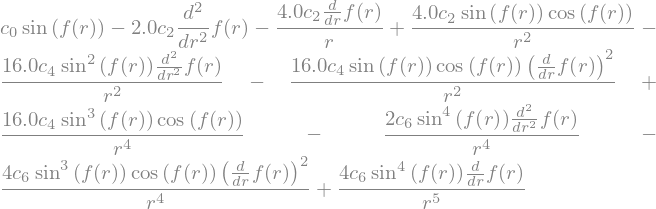

In [12]:
# Equation of motion for the profile function
Eqf = 1/gdet_sqrt*sp.diff(gdet_sqrt*sp.diff(Lag, sp.diff(f,r)), r) - sp.diff(Lag, f)

Eqf = sp.expand(Eqf)
Eqf

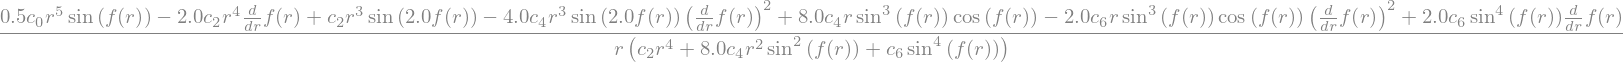

In [13]:
# Solve the expression
ddf = sp.simplify(sp.solve(Eqf, sp.diff(f,r,r))[0])

ddf

# Isospin inertia tensor
## $T_a = U^{\dagger}[U, \tau_a]$
## $\Lambda = \int d^3x (-\frac{a}{2} Tr\{T^2_a\} + b Tr\{[T_a, L_k]^2\} + )$

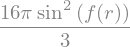

In [14]:
T3 = sp.I/2*Udagger*(tau3*U - U*tau3)

Lambda33_2 = sp.simplify(-sp.Trace(T3*T3))

Lambda33_2 = sp.integrate(sp.sin(theta)*Lambda33_2, (theta, 0, sp.pi))
Lambda33_2 = sp.integrate(Lambda33_2, (phi, 0, 2*sp.pi))

Lambda33_2

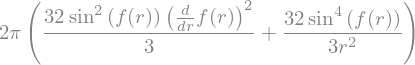

In [15]:
Lambda33_4 = 0
for i in range(3):
    for j in range(3):
        Lambda33_4 += sp.Trace(g.uu(i,j)*(T3*Lmu[i]-Lmu[i]*T3)*(T3*Lmu[j]-Lmu[j]*T3))
        
Lambda33_4 = sp.simplify(Lambda33_4)

Lambda33_4 = sp.integrate(sp.sin(theta)*Lambda33_4, (theta, 0, sp.pi))
Lambda33_4 = sp.integrate(Lambda33_4, (phi, 0, 2*sp.pi))

Lambda33_4

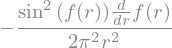

In [16]:
# Spatial components of the topological current B^i
Bi = []
for i in range(3):
    comps = 0
    for j in range(3):
        for k in range(3):
            comps += sp.simplify(sp.LeviCivita(i,j,k)*sp.trace(T3*Lmu[j]*Lmu[k]))
    Bi.append(3/(gdet_sqrt*24*sp.pi**2)*comps)

Bi[2]

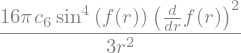

In [17]:
Lambda33_6 = 0
for i in range(3):
    for j in range(3):
        Lambda33_6 -= sp.simplify(g.dd(i,j)*Bi[i]*Bi[j])

Lambda33_6 = 8*sp.pi**4*c6*sp.integrate(sp.sin(theta)*Lambda33_6, (theta, 0, sp.pi))
Lambda33_6 = sp.integrate(Lambda33_6, (phi, 0, 2*sp.pi))

Lambda33_6

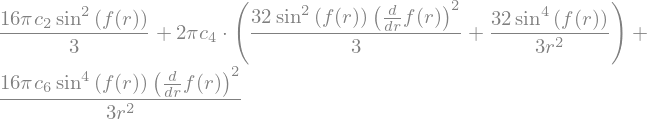

In [18]:
Lambda33 = c2*Lambda33_2 + c4*Lambda33_4 + Lambda33_6

Lambda33

# Skyrme crystals

In [19]:
from sympy.physics.quantum.dagger import Dagger

In [20]:
# Define the fundamental Skyrme theory fields
sigma = sp.Symbol('\sigma', real = True)
pi1 = sp.Symbol('\pi_1', real = True)
pi2 = sp.Symbol('\pi_2', real = True)
pi3 = sp.Symbol('\pi_3', real = True)

dsigma = sp.Symbol('\partial_{i} \sigma', real = True)
dpi1 = sp.Symbol('\partial_{i} \pi_1', real = True)
dpi2 = sp.Symbol('\partial_{i} \pi_2', real = True)
dpi3 = sp.Symbol('\partial_{i} \pi_3', real = True)

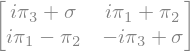

In [21]:
# SU(2) expansion of the Skyrme field
U = sp.Matrix([[sigma+sp.I*pi3, sp.I*pi1+pi2], 
               [sp.I*pi1 - pi2, sigma-sp.I*pi3]])

Udagger = Dagger(U)

# Derivative of the field
dU = sp.Matrix([[dsigma+sp.I*dpi3, sp.I*dpi1+dpi2], 
                [sp.I*dpi1 - dpi2, dsigma-sp.I*dpi3]])

dUdagger = Dagger(dU)

U

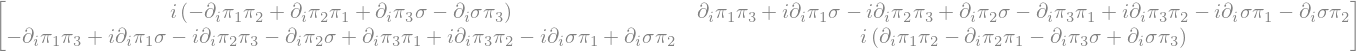

In [22]:
# Redefine the left invariant Maurer-Cartan form for this ansatz
L_i = sp.simplify(sp.expand(Udagger*dU))
L_i = sp.simplify(sp.expand(L_i.subs(pi1*dpi1, -sigma*dsigma - pi2*dpi2 - pi3*dpi3)))

L_i

# Isospin inertia tensor

In [23]:
# Define an additional Maurer-Cartan form with another index
djpi1 = sp.Symbol('\partial_{j} \pi_1')
djpi2 = sp.Symbol('\partial_{j} \pi_2')
djpi3 = sp.Symbol('\partial_{j} \pi_3')
djsigma = sp.Symbol('\partial_{j} \sigma')

L_j = L_i.subs(dpi1, djpi1).subs(dpi2, djpi2).subs(dpi3, djpi3).subs(dsigma, djsigma)

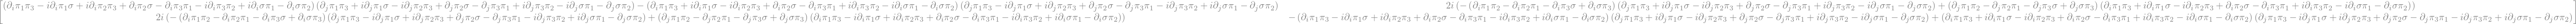

In [24]:
# Define the conmutator of both forms
L_conm = sp.simplify(L_i*L_j - L_j*L_i)

L_conm

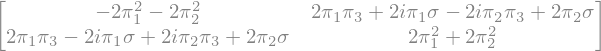

In [25]:
a = 2
T_a = sp.simplify(sp.expand(Udagger*(tau[a]*U - U*tau[a])))

T_a

In [26]:
# Lambda_2
Lambda_2 = sp.simplify(sp.expand(sp.Trace(T_a*T_a)))
if a == 0:
    Lambda_2 = sp.simplify(sp.expand(Lambda_2.subs(pi1**2, 1 - sigma**2 - pi2**2 - pi3**2)))/4
if a == 1:
    Lambda_2 = sp.simplify(sp.expand(Lambda_2.subs(pi2**2, 1 - sigma**2 - pi1**2 - pi3**2)))/4
if a == 2:
    Lambda_2 = sp.simplify(sp.expand(Lambda_2.subs(pi3**2, 1 - sigma**2 - pi1**2 - pi2**2)))/4

Lambda_2

In [27]:
# Lambda_4
Lambda_4 = sp.simplify(sp.expand(sp.Trace((T_a*L_i - L_i*T_a)**2)))
Lambda_4 = sp.simplify(sp.expand(Lambda_4.subs(sigma*dsigma, -pi1*dpi1 - pi2*dpi2 - pi3*dpi3)))
Lambda_4 = sp.simplify(sp.expand(Lambda_4.subs(sigma**2, 1 - pi1**2 - pi2**2 - pi3**2)))
if a == 0:
    Lambda_4 = sp.simplify(sp.expand(Lambda_4.subs(pi3*dpi3, -sigma*dsigma - pi1*dpi1 - pi2*dpi2)))
    Lambda_4 = sp.simplify(sp.expand(Lambda_4.subs(pi3**2, 1 - sigma**2 - pi1**2 - pi2**2)))/4
if a == 1:
    Lambda_4 = sp.simplify(sp.expand(Lambda_4.subs(pi1*dpi1, -sigma*dsigma - pi2*dpi2 - pi3*dpi3)))
    Lambda_4 = sp.simplify(sp.expand(Lambda_4.subs(pi1**2, 1 - sigma**2 - pi2**2 - pi3**2)))/4
if a == 2:
    Lambda_4 = sp.simplify(sp.expand(Lambda_4.subs(pi2*dpi2, -sigma*dsigma - pi1*dpi1 - pi3*dpi3)))
    Lambda_4 = sp.simplify(sp.expand(Lambda_4.subs(pi2**2, 1 - sigma**2 - pi1**2 - pi3**2)))/4

Lambda_4

In [28]:
# Lambda_6
Lambda_6 = sp.simplify(sp.expand(sp.Trace(L_conm*T_a)))
Lambda_6 = sp.simplify(sp.expand(Lambda_6.subs(sigma*dsigma, -pi1*dpi1 - pi2*dpi2 - pi3*dpi3)))
Lambda_6 = sp.simplify(sp.expand(Lambda_6.subs(sigma*djsigma, -pi1*djpi1 - pi2*djpi2 - pi3*djpi3)))
Lambda_6 = sp.simplify(sp.expand(Lambda_6.subs(sigma**2, 1 - pi1**2 - pi2**2 - pi3**2)))
if a == 0:
    Lambda_6 = sp.simplify(sp.expand(Lambda_6.subs(pi3*dpi3, -sigma*dsigma - pi1*dpi1 - pi2*dpi2)))
    Lambda_6 = sp.simplify(sp.expand(Lambda_6.subs(pi3*djpi3, -sigma*djsigma - pi1*djpi1 - pi2*djpi2)))
    Lambda_6 = sp.simplify(sp.expand(Lambda_6.subs(pi3**2, 1 - sigma**2 - pi1**2 - pi2**2)))
elif a == 1:
    Lambda_6 = sp.simplify(sp.expand(Lambda_6.subs(pi1*dpi1, -sigma*dsigma - pi2*dpi2 - pi3*dpi3)))
    Lambda_6 = sp.simplify(sp.expand(Lambda_6.subs(pi1*djpi1, -sigma*djsigma - pi2*djpi2 - pi3*djpi3)))
    Lambda_6 = sp.simplify(sp.expand(Lambda_6.subs(pi1**2, 1 - sigma**2 - pi2**2 - pi3**2)))
elif a == 2:
    Lambda_6 = sp.simplify(sp.expand(Lambda_6.subs(pi2*dpi2, -sigma*dsigma - pi1*dpi1 - pi3*dpi3)))
    Lambda_6 = sp.simplify(sp.expand(Lambda_6.subs(pi2*djpi2, -sigma*djsigma - pi1*djpi1 - pi3*djpi3)))
    Lambda_6 = sp.simplify(sp.expand(Lambda_6.subs(pi2**2, 1 - sigma**2 - pi1**2 - pi3**2)))

Lambda_6 = -c6*sp.simplify(Lambda_6**2/32)

Lambda_6